In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import ml_insights as mli

# To Plot matplotlib figures inline on the notebook
%matplotlib inline

from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from collections import OrderedDict

In [689]:
## Load in the boxofficemojo data - top 100 domestic total gross for years 2006-2016
datafile = "movies.csv"
df=pd.read_csv(datafile).dropna()
df['LBudget'] = pd.DataFrame(np.log(df['Budget']))
df['LDomestic Gross'] = pd.DataFrame(np.log(df['Domestic Gross']))
df['LForeign Gross'] = pd.DataFrame(np.log(df['Foreign Gross']))
df['LOpening Weekend'] = pd.DataFrame(np.log(df['Opening Weekend']))

In [690]:
## Get rid of Unnamed first column, generated when creating the csv from the scraped data
df.info()
smaller_df = df.loc[:,'Title':]
smaller_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737 entries, 0 to 1088
Data columns (total 17 columns):
Unnamed: 0          737 non-null int64
Title               737 non-null object
Rating              737 non-null object
Genre               737 non-null object
Director            737 non-null object
Producer            737 non-null object
Foreign Gross       737 non-null float64
Opening Weekend     737 non-null int64
Widest Release      737 non-null int64
Budget              737 non-null float64
Release Date        737 non-null object
Domestic Gross      737 non-null int64
Runtime             737 non-null int64
LBudget             737 non-null float64
LDomestic Gross     737 non-null float64
LForeign Gross      737 non-null float64
LOpening Weekend    737 non-null float64
dtypes: float64(6), int64(5), object(6)
memory usage: 103.6+ KB


,Title,Rating,Genre,Director,Producer,Foreign Gross,Opening Weekend,Widest Release,Budget,Release Date,Domestic Gross,Runtime,LBudget,LDomestic Gross,LForeign Gross,LOpening Weekend
0,Pirates of the Caribbean: Dead Man's Chest,PG-13,Period Adventure,Gore Verbinski,Jerry Bruckheimer,642863913.0,135634554,4133,225000000.0,2006-07-07,423315812,151,19.231611,19.863629,20.281444,18.725475
2,Cars,G,Animation,John Lasseter,Darla K. Anderson,218133298.0,60119509,3988,120000000.0,2006-06-09,244082982,116,18.603002,19.313019,19.200617,17.911845
3,X-Men: The Last Stand,PG-13,Action / Adventure,Brett Ratner,Avi Arad,224997093.0,102750665,3714,210000000.0,2006-05-26,234362462,104,19.162618,19.272379,19.231598,18.447816
4,The Da Vinci Code,PG-13,Thriller,Ron Howard,Brian Grazer,540703713.0,77073388,3757,125000000.0,2006-05-19,217536138,149,18.643824,19.197876,20.108382,18.160269
5,Superman Returns,PG-13,Action / Adventure,Bryan Singer,Gilbert Adler,191000000.0,52535096,4065,270000000.0,2006-06-28,200081192,154,19.413933,19.114234,19.067784,17.776992


In [691]:
len(smaller_df)

737

In [692]:
smaller_df = smaller_df.loc[:,
            ['LForeign Gross', 'LOpening Weekend', 'Widest Release', 'LBudget', 'LDomestic Gross', 'Runtime']].dropna()

# ***Challenge 1***

In [693]:
lr_model1 = LinearRegression(fit_intercept=False)

In [694]:
y = smaller_df['LDomestic Gross']

X = pd.DataFrame(np.array(len(smaller_df)*[1]))

In [695]:
lr_model1.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [696]:
lr_model1.coef_, lr_model1.intercept_

(array([ 18.20528786]), 0.0)

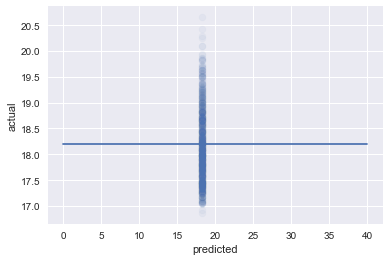

In [700]:
# The simple model with all X a constant value of 1 generates a model that predicts the mean(y)
plt.scatter(lr_model1.predict(X),y,alpha=.05)

plt.xlabel('predicted')
plt.ylabel('actual')
vec1 = np.linspace(0,40,1000)
# plot a line to show the mean(y)
plt.plot(vec1, len(vec1)*[lr_model1.coef_[0]]);


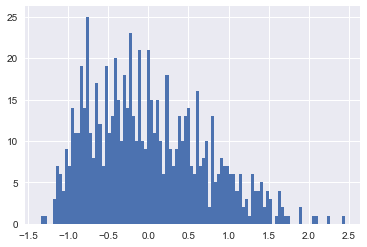

In [701]:
# The residuals look roughly normally distributed
residuals = (list(y) - lr_model1.coef_[0]*X[0])

plt.hist(residuals, bins=100);


# ***Challenge 2***

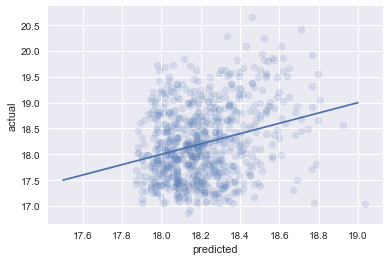

In [705]:
lr_model2 = LinearRegression()
X = pd.DataFrame(smaller_df['Runtime'])
lr_model2.fit(X,y)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.scatter(lr_model2.predict(X), y, alpha=0.15)
vec1 = np.linspace(17.5,19,1000)
plt.plot(vec1, vec1);


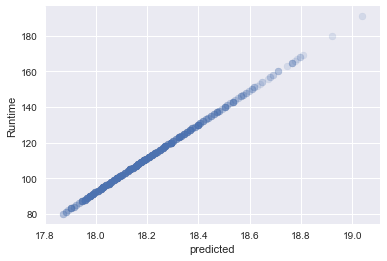

In [706]:
# Since the model is based on just one variable, the resulting model is a perfect linear function of it
plt.xlabel('predicted')
plt.ylabel('Runtime')
plt.scatter(lr_model2.predict(X), X['Runtime'], alpha=0.15);

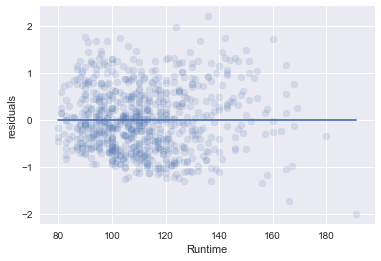

In [708]:
# Residuals are going to vary around Runtime since the model is poor
residuals = y - lr_model2.predict(X)
plt.ylabel('residuals')
plt.xlabel('Runtime')
plt.plot(np.linspace(np.min(df['Runtime']),np.max(df['Runtime']),1000), np.linspace(0,0,1000))
plt.scatter(X['Runtime'], residuals, alpha=0.15);

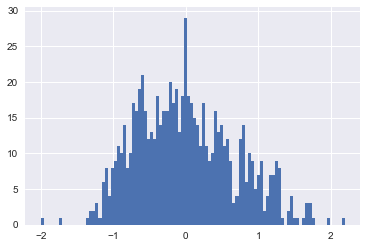

In [709]:
plt.hist(residuals, bins=100);

# ***Challenge 3***

In [710]:
df_gdummies = pd.get_dummies(df['Genre'])
#df2 = pd.concat([smaller_df, df_gdummies], axis=1)


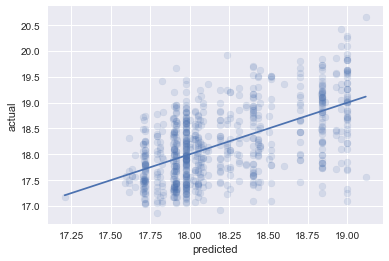

In [732]:
lr_model3 = LinearRegression()
X = pd.DataFrame(df_gdummies)
lr_model3.fit(X,y)
plt.xlabel('predicted')
plt.ylabel('actual')
pred = lr_model3.predict(X)
plt.scatter(pred, y,alpha=0.15)
vec1 = np.linspace(np.min(pred), np.max(pred),1000)
plt.plot(vec1, vec1);



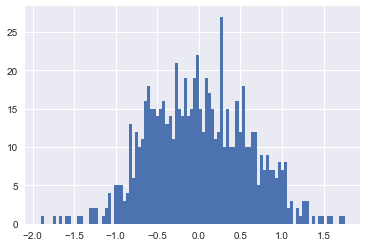

In [733]:
residuals = y - lr_model3.predict(X)

plt.hist(residuals, bins=100);

In [734]:
# visualizing significance of coefficients

def coefdisp(model, X):
    a = list(zip(X.columns, model.coef_))
    a.sort(key=lambda x: abs(x[1]), reverse=True)
    b = OrderedDict(a)
    #print(b)
    fig = plt.figure(figsize=(20,15))
    [plt.text(x,abs(y[1]),y[0], color='red' if np.sign(y[1])<0 else 'black',
              rotation=35, 
              horizontalalignment='left', 
              verticalalignment='bottom', 
              fontsize=12) 
         for x,y in enumerate(b.items())
    ]

    vals = np.abs(np.array(list(b.values())))
    plt.xlabel("Feature Index", fontsize=20)
    plt.ylabel("Abs(Feature Coefficient) - Negative feature values in red", fontsize=20)
    plt.plot(vals, 'g*', markersize=12)
    plt.plot(vals);
    

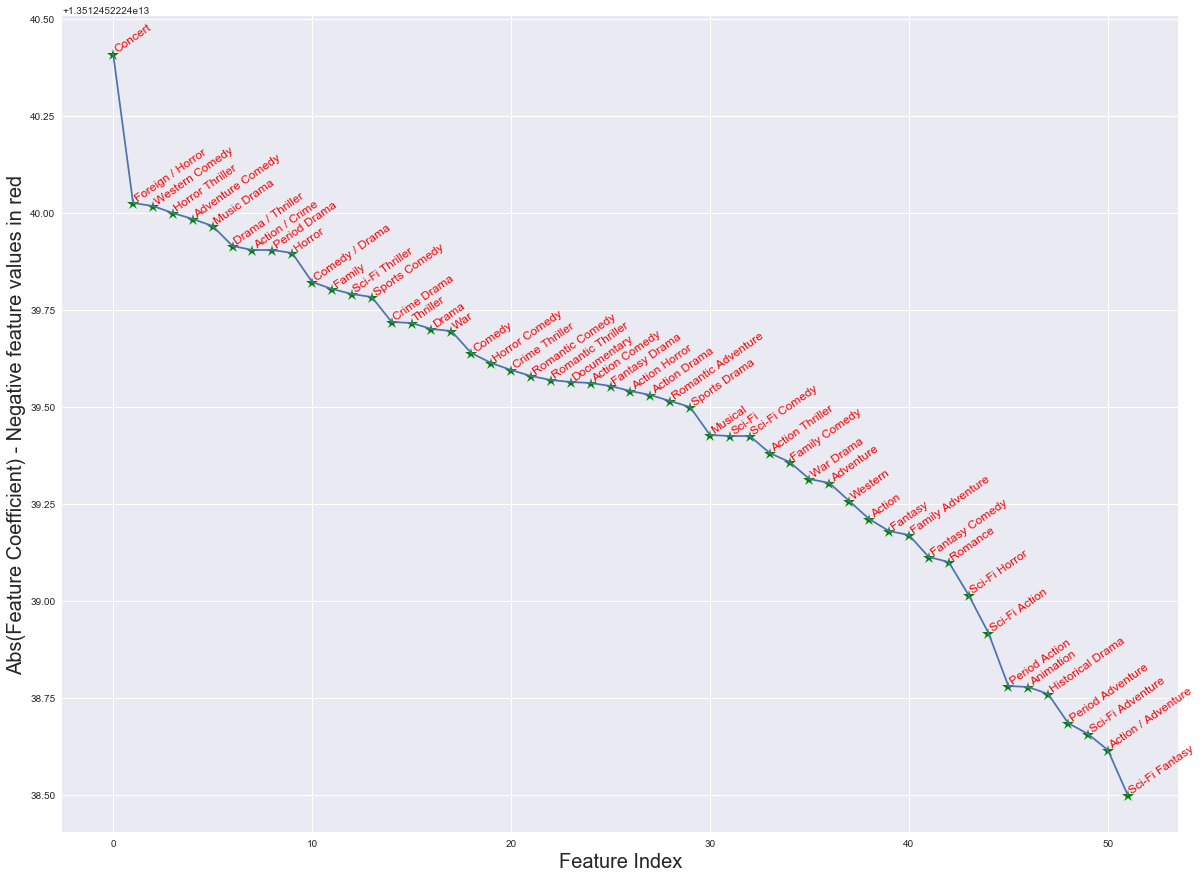

In [735]:

coefdisp(lr_model3, X)

# ***Challenge 4***

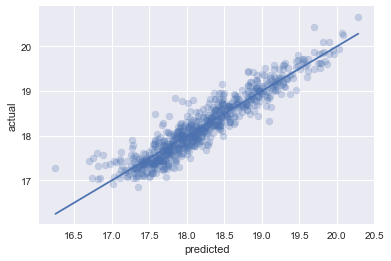

In [736]:
# I'm using most the features here, with large-valued numerics replaced with their logs

df_rdummies = pd.get_dummies(df['Rating'])
df2 = pd.concat([smaller_df, df_gdummies, df_rdummies], axis=1)
#X = df2.loc[:,['Foreign Gross', 'Opening Weekend', 'Widest Release', 'Budget', 'Runtime']
#            + list(df['Genre'].unique()) + list(df['Rating'].unique())]
X = df2.loc[:,[x != 'LDomestic Gross' for x in df2.columns]]

lr_model4 = LinearRegression()
lr_model4.fit(X,y)
plt.xlabel('predicted')
plt.ylabel('actual')
pred = lr_model4.predict(X)
plt.scatter(pred, y, alpha=0.25)
vec1 = np.linspace(np.min(pred), np.max(pred),1000)
plt.plot(vec1, vec1);




In [737]:
lr_model4.score(X,y)

0.88107514324792446

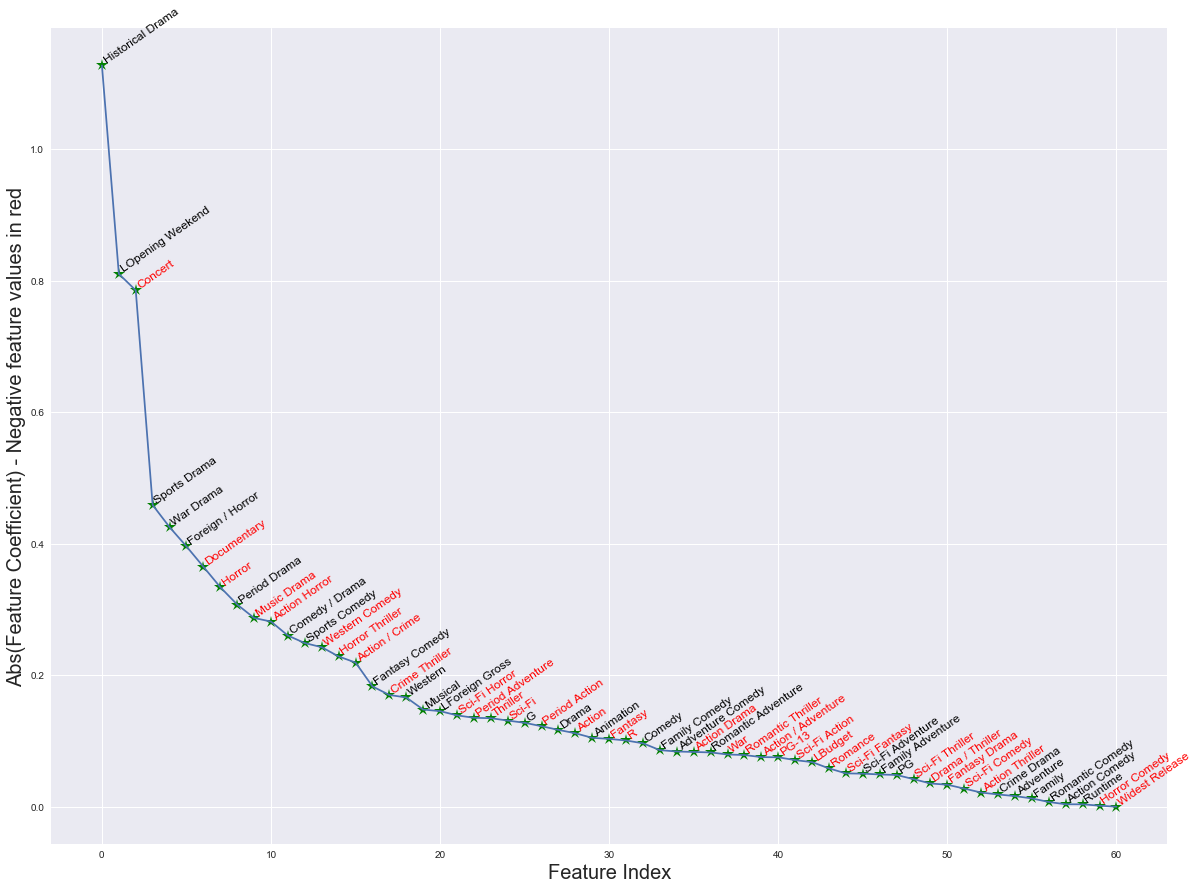

In [738]:
# visualizing significance of coefficients

coefdisp(lr_model4, X)

# ***Challenge 5***

In [739]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

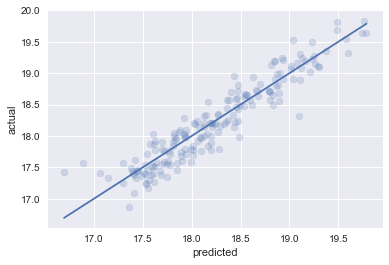

In [740]:
lr_model5 = LinearRegression()
lr_model5.fit(X_train, y_train)
plt.xlabel('predicted')
plt.ylabel('actual')
pred = lr_model4.predict(X_test)
plt.scatter(pred, y_test, alpha=.2)
vec1 = np.linspace(np.min(pred), np.max(pred),1000)
plt.plot(vec1, vec1);

In [741]:
lr_model5.score(X_test, y_test)

0.85168021482686573

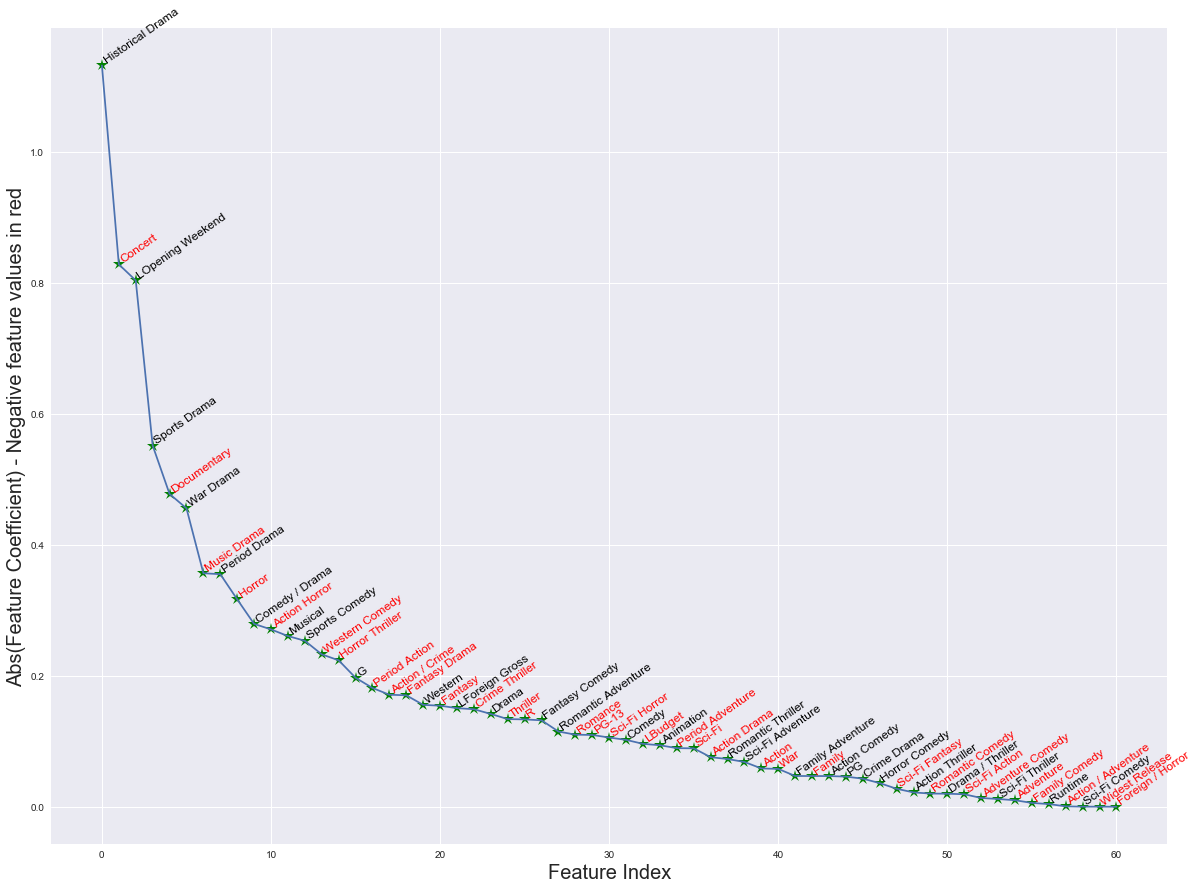

In [742]:
# visualizing significance of coefficients

coefdisp(lr_model5, X_test)